In [1]:
import torch
from torch import optim
from torch.utils.data import Subset, Dataset, DataLoader, IterableDataset, TensorDataset
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image
from tqdm import tqdm
from datetime import datetime
from torch.amp import autocast
import math
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
# req torch, torchvision, einops, tqdm, ema_pytorch, accelerate
from IPython.display import display
from einops import rearrange, reduce, repeat
import glob
from ema_pytorch import EMA
from scipy.optimize import linear_sum_assignment
from accelerate import Accelerator
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple

import os
CWD = os.getcwd()

# Device stuff
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Remember to use {device} device from here on")
print(os.chdir("../"))
# %cd /home/physics/phuqza/E9/DDPM-HL-LHC/
from DDPMLHC.config import *
from DDPMLHC.calculate_quantities import *
from DDPMLHC.data_loading import *
from DDPMLHC.generate_plots.overlaid_1d import create_overlay_plots
from DDPMLHC.generate_plots.bmap import save_to_bmap


# Some functions from denoising_diffusion_pytorch that are required but couldn't import
def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/physics/phuftc/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True
GPU Device: NVIDIA RTX A4000
Number of GPUs: 1
Remember to use cuda device from here on
None


In [2]:
def show_tensor_images(tensor_images, scale_factor=8):
    to_pil = T.ToPILImage()
    pil_images = [to_pil(image) for image in tensor_images]

    for img in pil_images:
        # Upscale the image
        upscaled_img = img.resize(
            (img.width * scale_factor, img.height * scale_factor), 
            Image.NEAREST  # or Image.BOX for smoother results
        )
        display(upscaled_img)


In [3]:
# Function to load last checkpoint and train the model
# def load_and_train(
#     diffusion,
#     dataloader,
#     num_epochs,
#     device,
#     save_dir,
#     lr=1e-4
# ):
#     os.makedirs(save_dir, exist_ok=True)
    
#     # Get last epoch number
#     checkpoint_files = glob.glob(os.path.join(save_dir, 'checkpoint_epoch_*.pth'))
#     last_epoch = 0
#     if checkpoint_files:
#         epoch_numbers = []
#         for f in checkpoint_files:
#             try:
#                 epoch_num = int(f.split('epoch_')[1].split('_loss')[0])
#                 epoch_numbers.append(epoch_num)
#             except:
#                 continue
#         last_epoch = max(epoch_numbers) if epoch_numbers else 0

#     # Load checkpoint if exists
#     if last_epoch > 0:
#         checkpoint_pattern = os.path.join(save_dir, f'checkpoint_epoch_{last_epoch}_*.pth')
#         checkpoint_file = glob.glob(checkpoint_pattern)[0]
#         print(f"Loading checkpoint: {checkpoint_file}")
#         checkpoint = torch.load(checkpoint_file, map_location=device)
#         diffusion.load_state_dict(checkpoint['model_state_dict'])
#     else:
#         print("Starting fresh training")

#     optimizer = optim.Adam(diffusion.parameters(), lr=lr, betas=(0.9,0.999))
#     # batch = len(dataloader)
#     # for epoch in range(last_epoch, last_epoch + num_epochs):
#     #     running_loss = 0.
#     #     last_loss = 0.
#     #     print(f"\nEpoch {epoch + 1}/{last_epoch + num_epochs}")
#         # diffusion.train(True)
#         # for i,batch_data in enumerate(dataloader):
#         #     batch_data = batch_data.to(device)
#         #     optimizer.zero_grad()
#         #     loss = diffusion()  # Ensure targets are correctly defined and batched
#         #     loss.backward()
#         #     optimizer.step()
#         #     running_loss += loss.item()

#         #     print(f'Train Loss: {loss.item():.4f}')
#         #     if i % 100 == 0:
#         #         last_loss = running_loss / 1 # loss per batch
#         #         print('  batch {} loss: {}'.format(i + 1, last_loss))
#         #         tb_x = epoch_index * len(training_loader) + i + 1
#         #         tb_writer.add_scalar('Loss/train', last_loss, tb_x)
#         #         running_loss = 0.

#         # checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}_loss_{last_loss:.4f}.pth')
#         # torch.save({
#         #     'epoch': epoch,
#         #     'model_state_dict': diffusion.state_dict(),
#         #     'optimizer_state_dict': optimizer.state_dict(),
#         #     'loss': last_loss,
#         # }, checkpoint_path)
#         # print(f'Checkpoint saved: {checkpoint_path}')
#     progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))

#     running_loss = 0.0
#     loss_array = []
#     for i, images in progress_bar:
#         images = images.to(device)
#         optimizer.zero_grad()
#         loss = diffusion(images)
#         loss.backward()
#         optimizer.step()
#         loss_array.append(loss)
#         running_loss += loss.item()
#         # print(running_loss)
#         avg_loss = running_loss / (i + 1)
#         # avg_loss = np.mean(loss_array)
#         progress_bar.set_postfix({'Loss': f'{avg_loss:.4f}'})

#     # Save checkpoint at the end of each epoch
#     checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}_loss_{avg_loss:.4f}.pth')
#     torch.save({
#         'epoch': epoch,
#         'model_state_dict': diffusion.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': avg_loss,
#     }, checkpoint_path)
#     print(f'Checkpoint saved: {checkpoint_path}')


## Custom reimplementation of Trainer from DDPM
## Avoid subclassing because we do not want to pass in literal files

class PUTrainer():
    def __init__(
        self,
        diffusion_model,
        dataloader,
        train_batch_size = 100,
        gradient_accumulate_every = 1,
        augment_horizontal_flip = True,
        train_lr = 1e-4,
        train_num_steps = 200,
        ema_update_every = 10,
        ema_decay = 0.995,
        adam_betas = (0.9, 0.99),
        save_and_sample_every = 1000,
        num_samples = 25,
        results_folder = './ML/results',
        amp = False,
        mixed_precision_type = 'fp32',
        split_batches = True,
        convert_image_to = None,
        calculate_fid = True,
        inception_block_idx = 2048,
        max_grad_norm = 1.,
        num_fid_samples = 50000,
        save_best_and_latest_only = False
    ):
        super().__init__()

        # accelerator

        self.accelerator = Accelerator(
            split_batches = split_batches,
            mixed_precision = mixed_precision_type if amp else 'no'
        )

        # model

        self.model = diffusion_model
        self.channels = diffusion_model.channels
        # is_ddim_sampling = diffusion_model.is_ddim_sampling

        # default convert_image_to depending on channels

        # if not exists(convert_image_to):
        #     convert_image_to = {1: 'L', 3: 'RGB', 4: 'RGBA'}.get(self.channels)

        # sampling and training hyperparameters

        # assert has_int_squareroot(num_samples), 'number of samples must have an integer square root'
        self.num_samples = num_samples
        self.save_and_sample_every = save_and_sample_every

        self.batch_size = train_batch_size
        self.gradient_accumulate_every = gradient_accumulate_every
        assert (train_batch_size * gradient_accumulate_every) >= 16, f'your effective batch size (train_batch_size x gradient_accumulate_every) should be at least 16 or above'

        self.train_num_steps = train_num_steps
        self.image_size = diffusion_model.image_size

        self.max_grad_norm = max_grad_norm

        # dataset and dataloader

        # self.ds = Dataset(folder, self.image_size, augment_horizontal_flip = augment_horizontal_flip, convert_image_to = convert_image_to)
        # self.ds = dataset
        # # assert len(self.ds) >= 100, 'you should have at least 100 images in your folder. at least 10k images recommended'

        # dl = DataLoader(self.ds, batch_size = train_batch_size, shuffle = True, pin_memory = True, num_workers = cpu_count())
        dl = dataloader
        print(dl)

        dl = self.accelerator.prepare(dl)
        print(len(dl))
        self.dl = self.cycle(dl=dl)

        # optimizer

        self.opt = optim.Adam(diffusion_model.parameters(), lr = train_lr, betas = adam_betas)

        # for logging results in a folder periodically

        if self.accelerator.is_main_process:
            self.ema = EMA(diffusion_model, beta = ema_decay, update_every = ema_update_every)
            # print("EMA model", self.ema.ema_model)
            self.ema.to(self.device)

        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(exist_ok = True)

        # step counter state

        self.step = 0

        # prepare model, dataloader, optimizer with accelerator

        self.model, self.opt = self.accelerator.prepare(self.model, self.opt)

        # FID-score computation

        self.calculate_fid = calculate_fid and self.accelerator.is_main_process

        # if self.calculate_fid:
        #     from denoising_diffusion_pytorch.fid_evaluation import FIDEvaluation

        #     if not is_ddim_sampling:
        #         self.accelerator.print(
        #             "WARNING: Robust FID computation requires a lot of generated samples and can therefore be very time consuming."\
        #             "Consider using DDIM sampling to save time."
        #         )

        #     self.fid_scorer = FIDEvaluation(
        #         batch_size=self.batch_size,
        #         dl=self.dl,
        #         sampler=self.ema.ema_model,
        #         channels=self.channels,
        #         accelerator=self.accelerator,
        #         stats_dir=results_folder,
        #         device=self.device,
        #         num_fid_samples=num_fid_samples,
        #         inception_block_idx=inception_block_idx
        #     )

        if save_best_and_latest_only:
            assert calculate_fid, "`calculate_fid` must be True to provide a means for model evaluation for `save_best_and_latest_only`."
            self.best_fid = 1e10 # infinite

        self.save_best_and_latest_only = save_best_and_latest_only
    def cycle(self, dl):
        while True:
            for data in dl:
                yield data
    @property
    def device(self):
        return self.accelerator.device

    def save(self, i):
        if not self.accelerator.is_local_main_process:
            return

        data = {
            'step': self.step,
            'model': self.accelerator.get_state_dict(self.model),
            'opt': self.opt.state_dict(),
            'ema': self.ema.state_dict(),
            'scaler': self.accelerator.scaler.state_dict() if self.accelerator.scaler is not None else None,
        }

        torch.save(data, str(self.results_folder / f'model-step{i}.pth'))

    def load(self, milestone):
        accelerator = self.accelerator
        device = accelerator.device

        data = torch.load(str(self.results_folder / f'model-{milestone}.pth'), map_location=device, weights_only=True)

        model = self.accelerator.unwrap_model(self.model)
        model.load_state_dict(data['model'])

        self.step = data['step']
        self.opt.load_state_dict(data['opt'])
        if self.accelerator.is_main_process:
            self.ema.load_state_dict(data["ema"])

        if 'version' in data:
            print(f"loading from version {data['version']}")

        if exists(self.accelerator.scaler) and exists(data['scaler']):
            self.accelerator.scaler.load_state_dict(data['scaler'])

    def num_to_groups(self,num, divisor):
        groups = num // divisor
        remainder = num % divisor
        arr = [divisor] * groups
        if remainder > 0:
            arr.append(remainder)
        return arr
    def train(self):
        accelerator = self.accelerator
        device = accelerator.device

        with tqdm(initial = self.step, total = self.train_num_steps, disable = not accelerator.is_main_process) as pbar:

            while self.step < self.train_num_steps:
                self.model.train()

                total_loss = 0.

                for _ in range(self.gradient_accumulate_every):
                    data = next(self.dl).to(device)

                    with self.accelerator.autocast():
                        loss = self.model(data)
                        loss = loss / self.gradient_accumulate_every
                        total_loss += loss.item()

                    self.accelerator.backward(loss)

                pbar.set_description(f'loss: {total_loss:.4f}')

                accelerator.wait_for_everyone()
                accelerator.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)

                self.opt.step()
                self.opt.zero_grad()

                accelerator.wait_for_everyone()

                self.step += 1
                if accelerator.is_main_process:
                    self.ema.update()
                    divisible_by = (self.step % self.save_and_sample_every) == 0
                    # print("???")
                    if self.step != 0 and divisible_by:
                        self.ema.ema_model.eval()

                        with torch.inference_mode():
                            milestone = self.step // self.save_and_sample_every
                            batches = self.num_to_groups(self.num_samples, self.batch_size)
                            print(f"right before all_images_list, step {self.step}")
                            # print("tt", self.ema.ema_model.jetNG)
                            # all_images_list = list(map(lambda n: self.ema.ema_model.sample(batch_size=n), batches))
                            all_images_list = self.ema.ema_model.sample(batch_size=4)

                        # all_images = torch.cat(all_images_list, dim = 0)

                        # utils.save_image(all_images, str(self.results_folder / f'sample-{milestone}.png'), nrow = int(math.sqrt(self.num_samples)))

                        # whether to calculate fid

                        # if self.calculate_fid:
                        #     fid_score = self.fid_scorer.fid_score()
                        #     accelerator.print(f'fid_score: {fid_score}')

                        # if self.save_best_and_latest_only:
                        #     if self.best_fid > fid_score:
                        #         self.best_fid = fid_score
                        #         self.save("best")
                        #     self.save("latest")
                        # else:
                        if self.step % 10 == 0:
                            self.save(milestone)

                pbar.update(1)

        accelerator.print('training complete')


################################
def load_and_train(
    diffusion,
    dataloader,
    num_epochs,
    device,
    save_dir,
    lr=1e-4
):
    os.makedirs(save_dir, exist_ok=True)
    
    # Get last epoch number
    checkpoint_files = glob.glob(os.path.join(save_dir, 'checkpoint_epoch_*.pth'))
    last_epoch = 0
    if checkpoint_files:
        epoch_numbers = []
        for f in checkpoint_files:
            try:
                epoch_num = int(f.split('epoch_')[1].split('_loss')[0])
                epoch_numbers.append(epoch_num)
            except:
                continue
        last_epoch = max(epoch_numbers) if epoch_numbers else 0

    # Load checkpoint if exists
    if last_epoch > 0:
        checkpoint_pattern = os.path.join(save_dir, f'checkpoint_epoch_{last_epoch}_*.pth')
        checkpoint_file = glob.glob(checkpoint_pattern)[0]
        print(f"Loading checkpoint: {checkpoint_file}")
        checkpoint = torch.load(checkpoint_file, map_location=device)
        diffusion.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("Starting fresh training")

    optimizer = optim.Adam(diffusion.parameters(), lr=lr)

    for epoch in range(last_epoch, last_epoch + num_epochs):
        print(f"\nEpoch {epoch + 1}/{last_epoch + num_epochs}")
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))

        running_loss = 0.0
        for i, images in progress_bar:
            images = images.to(device)
            optimizer.zero_grad()
            loss = diffusion(images)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / (i + 1)
            progress_bar.set_postfix({'Loss': f'{avg_loss:.7f}'})

        # Save checkpoint at the end of each epoch
        checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}_loss_{avg_loss:.7f}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': diffusion.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')


In [4]:

MAX_DATA_ROWS = None

# === Read in data
print("0 :: Loading original data")
tt = np.genfromtxt(
    TT_PATH, delimiter=",", encoding="utf-8", skip_header=1, max_rows=MAX_DATA_ROWS
)
pu = np.genfromtxt(
    PILEUP_PATH, delimiter=",", encoding="utf-8", skip_header=1, max_rows=MAX_DATA_ROWS
)
tt = EventSelector(tt)
pu = EventSelector(pu)
print("FINISHED loading data\n")
bins=16
# Ground truth ttbar jets
NG_jet = NoisyGenerator(TTselector=tt, PUselector=pu, bins=bins, mu=0)
# Second one to randomly generate and return pile-up events ONLY
## Will use np.random.randint to generate NoisyGenerator.mu and then call next
NG_pu = NoisyGenerator(TTselector=tt, PUselector=pu, bins=bins, mu=0, pu_only=True)

# class OutData():
#     def __init__(self, vector, axis=(0,0)):
#         pass



0 :: Loading original data
FINISHED loading data



In [5]:
class NGenForDataloader(Dataset):
    def __init__(self, noisy_generator, njets=100):
        self.ng = noisy_generator
        self.jets = []
        self.njets = njets
        # next(self.ng)
    def __iter__(self):
        return self
    
    def __len__(self):
        return self.ng._max_TT_no - 1
    
    def __getitem__(self, idx):
        self.ng.select_jet(idx)
        x = torch.from_numpy( self.ng.get_grid() )
        # x = x.unsqueeze(0)
        x = x.unsqueeze(0)
        # self.jets.append(x)
        # print("x jet img", x.shape)
        # y = x
        return x

# class NGenForDataloader(IterableDataset):
#     def __init__(self, noisy_generator, batch_size=1, nsteps=1000):
#         super().__init__()
#         self.ng = noisy_generator # NoisyGenerator instance that feeds in jet data
#         self.batch_size = batch_size # batch_size should select batch_size number of jets
#         self.ng.reset()
#         self.nsteps = nsteps
#         self.current_jetno = self.ng._next_jetID
#         # next(self.ng)
    
#     # USING THIS TO MAKE IterableDataset for model
#     # So dataset is "streamed in" continously instead of specifically "selecting" a jet
#     # Hence in each timestep, 
#     def generate_jet(self):
         
#         #     if :
#         #         raise RuntimeError("Requested jet not in loaded set. Did nothing.")
#         #     # Define empty image tensor
#         # while True:
#         image_data = []
#         # images = torch.empty(size=(self.batch_size,1,self.ng.grid_side_bins,self.ng.grid_side_bins))
#         # Ensure that if the remainder of data cannot fit in batch_size, just fit thhe rest of the data into one batch
#         jet_range = range(self.ng._next_jetID, self.ng._next_jetID + batch_size) if self.ng._max_TT_no - self.ng._next_jetID > batch_size else range(self.ng._next_jetID, self.ng._max_TT_no)
#         for jet_no in jet_range:
#             self.ng.select_jet(jet_no) # Select jet, now self.ng.current_event is set
#             image = torch.from_numpy(self.ng.get_grid())# Converted to bins x bins image and now tensor
#             image_data.append(image)
#         # Now image_data is (self.batch_size, bins, bins)
#         image_data = torch.stack(image_data)
#         image_data = image_data.unsqueeze(1) # Add channels, set to 1
#         # image_data = image_data.to(device)
#         self.current_jetno = self.ng._next_jetID
#         # print("image shape 0:::", image_data[0,:,:,:])
#         return image_data
            
#     def __iter__(self):
#         while self.current_jetno < self.ng._max_TT_no:
#         # if 
#         #     self.ng.reset() # Reset for next cycle through the dataset
#             yield self.generate_jet()
#             if self.ng._next_jetID >= self.ng._max_TT_no:
#                 self.ng.reset()
#                 self.current_jetno = 0
#         # return self
#                 print("reset")
        
        
#     def __next__(self):
#         # if self.ng._next_jetID >= self.ng._max_TT_no:
#         #     self.ng.reset() # Reset for next cycle through the dataset
#         #     raise StopIteration  # Stops for loop after
#         # else: 
#         while self.current_jetno < self.ng._max_TT_no:
#         # if 
#         #     self.ng.reset() # Reset for next cycle through the dataset
#             yield self.generate_jet()
#             if self.ng._next_jetID >= self.ng._max_TT_no:
#                 self.ng.reset()
#                 self.current_jetno = 0
#         # raise StopIteration  # Stops for loop after
#             # return self.generate_jet()
#     def __len__(self):
#         return self.nsteps
    
#     def __getitem__(self, idx):
#         self.ng.select_jet(idx)
#         x = torch.from_numpy( self.ng.get_grid() )
#         # x = x.unsqueeze(0)
#         x = x.unsqueeze(0)
#         # y = x
#         return x

In [6]:
model = Unet(
    dim=64,                  # Base dimensionality of feature maps
    dim_mults=(1, 2, 4, 8),  # Multipliers for feature dimensions at each level
    channels=1,              # E.g. 3 for RGB
).to(device)

class PUDiffusion(GaussianDiffusion):
    def __init__(self, model, image_size, puNG: NoisyGenerator, jet_ng: NoisyGenerator,**kwargs):
        super(PUDiffusion, self).__init__(model=model, image_size=image_size, **kwargs)
        self.puNG = puNG
        self.jetNG = jet_ng
        self.channels = model.channels
        self.mu_counter = 1
    def cond_noise(self, x_shape, noise):
        return self.pu_to_tensor(x_shape) if noise is None else noise
        # return torch.zeros_like(x_start) if noise is None else noise
    def generate_data(self, shape, NG: NoisyGenerator):
        """
        This function generates image data matched to the correct shape
        """
        # Start next jet
        next(NG)
        selected = NG.get_grid()
        # If empty pile-up, return array of 0s instead since model should account for this
        if selected.size == 0:
            return  "Error in PUDiffusion.generate_jet"
        # print(selected_pu.shape)
        pu_tensor = torch.from_numpy(selected)

        pu_tensor = torch.unsqueeze(pu_tensor,0)
        # This tensor has dimensions BxCxHxW to match x_start
        pu_tensor = torch.unsqueeze(pu_tensor,0)
        pu_tensor = pu_tensor.expand(shape[0], shape[1], -1, -1) 
        pu_tensor = torch.zeros(shape)
        pu_tensor = pu_tensor.to(self.device)
        return pu_tensor
    def pu_to_tensor(self, shape):
        # Select random number of pile-ups (mu) to generate, max 200 for now since HL-LHC expected to do up to this
        # We are doing it per batch
        # if isinstance(t, int):
        #     mu = np.random.randint(low=1, high=200, size=None)
        # else:
        #     mu = np.random.randint(low=1, high=200, size=None)
        mu = 1
        # print(mu)
        NG = self.puNG
        NG.mu = mu
        NG.reset()
        # next(self.puNG)
        pu_tensor = self.generate_data(shape=shape, NG=NG)
        return pu_tensor
    def jet_to_tensor(self, shape):
        NG = self.jetNG
        # next(NG)
        pu_tensor = self.generate_data(shape=shape, NG=self.jetNG)
        return pu_tensor
    # TODO: ddim_sample???
    @torch.inference_mode()
    def p_sample(self, x, t: int, x_self_cond = None):
        b, *_, device = *x.shape, self.device
        batched_times = torch.full((b,), t, device = device, dtype = torch.long)
        # print("batched times", t)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, x_self_cond = x_self_cond, clip_denoised = True)
        ######## MODIFY
        noise = self.pu_to_tensor(x.shape) if t > 0 else 0 # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start
    @autocast('cuda', enabled = False)
    def q_sample(self, x_start, t, noise = None):
        noise = self.cond_noise(x_shape=x_start.shape, noise=noise)

        if self.immiscible:
            assign = self.noise_assignment(x_start, noise)
            noise = noise[assign]
        # print("q_sample t", t)
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )
    @torch.inference_mode()
    def p_sample_loop(self, shape, return_all_timesteps = False):
        # print("p sample loop")
        # print(shape)
        batch, device = shape[0], self.device

        # img = torch.randn(shape, device = device)
        # This function is called in PUTrainer to sample jets
        # img = self.
        # img = torch.zeros(shape)
        img = self.jet_to_tensor(shape=shape) # Geenerates a jet
        # img = img.to(self.device)
        imgs = [img]

        x_start = None

        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            self_cond = x_start if self.self_condition else None
            img, x_start = self.p_sample(img, t, self_cond)
            self.mu_counter +=1
            imgs.append(img)

        ret = img if not return_all_timesteps else torch.stack(imgs, dim = 1)

        ret = self.unnormalize(ret)
        return ret
    @torch.inference_mode()
    def sample(self, batch_size = 16, return_all_timesteps = False):
        (h, w), channels = self.image_size, self.channels
        # sample_fn = self.p_sample_loop if not self.is_ddim_sampling else self.ddim_sample
        sample_fn = self.p_sample_loop
        return sample_fn((batch_size, channels, h, w), return_all_timesteps = return_all_timesteps)

    @torch.inference_mode()
    def ddim_sample(self, shape, return_all_timesteps = False):
        # print("is ddim")
        batch, device, total_timesteps, sampling_timesteps, eta, objective = shape[0], self.device, self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps = sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

        img = torch.randn(shape, device = device)
        # img = self.cond_noise(x_start, sampling_timesteps)
        imgs = [img]

        x_start = None

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            time_cond = torch.full((batch,), time, device = device, dtype = torch.long)
            self_cond = x_start if self.self_condition else None
            pred_noise, x_start, *_ = self.model_predictions(img, time_cond, self_cond, clip_x_start = True, rederive_pred_noise = True)

            if time_next < 0:
                img = x_start
                imgs.append(img)
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            # noise = torch.randn_like(img)
            # noise = self.cond_noise(self_cond, noi)
            noise = self.pu_to_tensor(x_start.shape)

            img = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise

            imgs.append(img)

        ret = img if not return_all_timesteps else torch.stack(imgs, dim = 1)

        ret = self.unnormalize(ret)
        return ret


    def p_losses(self, x_start, t, noise = None, offset_noise_strength = None):
        b, c, h, w = x_start.shape
        # print(x_start.shape)
        # Select one pile-up at a time for each timestep $t$
        # single_pileup = self.pu.select_event(np.random.randint(low=0, high=self.pu.max_ID, size=1))
        # print("p_losses t", t)

        # noise = self.cond_noise(x_start.shape, noise=noise)
        noise = torch.zeros_like(x_start)

        # if noise is None: 
        # noise = default(noise, lambda: torch.randn_like(x_start))
        # offset_noise_strength = default(offset_noise_strength, self.offset_noise_strength)

        # if offset_noise_strength > 0:
        #     offset_noise = torch.randn(x_start.shape[:2], device = self.device)
        #     noise += offset_noise_strength * rearrange(offset_noise, 'b c -> b c 1 1')

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # if doing self-conditioning, 50% of the time, predict x_start from current set of times
        # and condition with unet with that
        # this technique will slow down training by 25%, but seems to lower FID significantly

        x_self_cond = None
        if self.self_condition and random() < 0.5:
            with torch.no_grad():
                x_self_cond = self.model_predictions(x, t).pred_x_start
                x_self_cond.detach_()

        # predict and take gradient step

        model_out = self.model(x, t, x_self_cond)

        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        elif self.objective == 'pred_v':
            v = self.predict_v(x_start, t, noise)
            target = v
        else:
            raise ValueError(f'unknown objective {self.objective}')

        loss = F.mse_loss(model_out, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b', 'mean')

        loss = loss * extract(self.loss_weight, t, loss.shape)
        return loss.mean()
    def forward(self, img, *args, **kwargs):
        # img = img.squeeze(0)
        # print("???", *img.shape)
        b, c, h, w, device, img_size, = *img.shape, img.device, self.image_size
        assert h == img_size[0] and w == img_size[1], f'height and width of image must be {img_size}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = self.normalize(img)
        return self.p_losses(img, t, *args, **kwargs)


# diffusion = GaussianDiffusion(
#     model = model,
#     image_size = 16,  # Size of your images (ensure your images are square)
#     timesteps = 1000,  # Number of diffusion steps
#     objective = "pred_x0",
# ).to(device)

diffusion = PUDiffusion(
    model = model,
    puNG = NG_pu,
    jet_ng= NG_jet,
    image_size = bins,  # Size of your images (ensure your images are square)
    timesteps = 200,  # Number of diffusion steps
    objective = "pred_x0",
    sampling_timesteps = None
).to(device)

sampling loop time step: 100%|██████████| 200/200 [00:02<00:00, 91.95it/s]


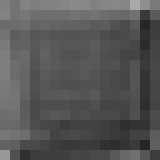

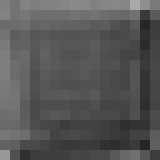

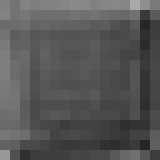

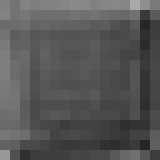

In [7]:
# Generate samples
batch_size = 4
NG_jet.reset()
NG_pu.reset()
sampled_images = diffusion.sample(batch_size=batch_size)
show_tensor_images(sampled_images, scale_factor=10)
# pats = [ng_for_dataloader[0],ng_for_dataloader[1],ng_for_dataloader[2],ng_for_dataloader[3],ng_for_dataloader[4],ng_for_dataloader[5], ng_for_dataloader[-1]]
# show_tensor_images(pats, scale_factor=10)

In [8]:
# this one is to be passed into DataLoader for training
train_batch_size = 100
ng_for_dataloader = NGenForDataloader(NG_jet)
# validation_jets = NGenForDataloader(NG_jet)
# ng_for_dataloader = NGenForDataloader(NG_jet, batch_size=100)
# We handle batching ourselves, by serving "batch_size" number of jets to train on each time
dataloader = DataLoader(ng_for_dataloader, batch_size=train_batch_size, num_workers=2, shuffle = True, pin_memory = True)
# validation_loader = DataLoader(ng_for_dataloader, batch_size=100, num_workers=2, shuffle = True, pin_memory = True)
# dataloader = DataLoader(ng_for_dataloader, pin_memory = True)
# print(dataloader)
#print(ng_for_dataloader)
# pats = [ng_for_dataloader[0],ng_for_dataloader[1],ng_for_dataloader[2],ng_for_dataloader[3],ng_for_dataloader[4],ng_for_dataloader[5], ng_for_dataloader[-1]]
# show_tensor_images(pats, scale_factor=10)
# print(tt.select_event(0).shape)
save_dir = f"{CWD}/data/ML/second"
num_epochs = 10


# print(f"{len(ng_for_dataloader)} jets, {pred_noise, x_start, *_ = self.model_predictions(img, time_cond, self_cond, clip_x_start = True, rederive_pred_noise = True)ng_for_dataloader.batch_size} batches, {num_epochs} epochs")
load_and_train(diffusion, dataloader, num_epochs=num_epochs, device=device, save_dir=save_dir, lr=1e-4)
# trainer_params = {
#         diffusion_model: PUDiffusion,
#         dataloader: dataloader,
#         train_batch_size: train_batch_size,
#         gradient_accumulate_every: 1,
#         augment_horizontal_flip : False,
#         train_lr: 1e-4,
#         train_num_steps : 200,
#         ema_update_every : 10,
#         ema_decay : 0.995,
#         adam_betas: (0.9, 0.99),
#         save_and_sample_every : 5,
#         num_samples : 25,
#         results_folder : './ML/results',
#         amp : False,
#         mixed_precision_type : 'fp32',
#         split_batches : True,
#         convert_image_to :None,
#         calculate_fid : False,
#         inception_block_idx : 2048,
#         max_grad_norm : 1.0,
#         num_fid_samples : 50000,
#         save_best_and_latest_only : False
# }
# trainer = PUTrainer(**trainer_params)
# trainer = PUTrainer(
#   diffusion,
#   dataloader,
#   train_batch_size = train_batch_size,
#   gradient_accumulate_every = 1,
#   augment_horizontal_flip = True,
#   train_lr = 1e-6,
#   train_num_steps = 100,
#   ema_update_every = 10,
#   ema_decay = 0.995,
#   adam_betas = (0.9, 0.99),
#   save_and_sample_every = 20,
#   num_samples = 100,
#   results_folder = f'{CWD}/data/ML/results',
#   amp = False,
#   mixed_precision_type = 'fp32',
#   split_batches = True,
#   convert_image_to = None,
#   calculate_fid = True,
#   inception_block_idx = 2048,
#   max_grad_norm = 1.,
#   num_fid_samples = 50000,
#   save_best_and_latest_only = False
#   )
# trainer.train()
print("Finished training")

Starting fresh training

Epoch 1/10


100%|██████████| 710/710 [00:46<00:00, 15.28it/s, Loss=0.0256]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_1_loss_0.0256.pth

Epoch 2/10


100%|██████████| 710/710 [00:46<00:00, 15.13it/s, Loss=0.0033]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_2_loss_0.0033.pth

Epoch 3/10


100%|██████████| 710/710 [00:47<00:00, 15.07it/s, Loss=0.0032]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_3_loss_0.0032.pth

Epoch 4/10


100%|██████████| 710/710 [00:47<00:00, 15.06it/s, Loss=0.0036]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_4_loss_0.0036.pth

Epoch 5/10


100%|██████████| 710/710 [00:47<00:00, 15.04it/s, Loss=0.0004]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_5_loss_0.0004.pth

Epoch 6/10


100%|██████████| 710/710 [00:47<00:00, 15.03it/s, Loss=0.0009]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_6_loss_0.0009.pth

Epoch 7/10


100%|██████████| 710/710 [00:47<00:00, 15.02it/s, Loss=0.0053]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_7_loss_0.0053.pth

Epoch 8/10


100%|██████████| 710/710 [00:47<00:00, 15.02it/s, Loss=0.0002]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_8_loss_0.0002.pth

Epoch 9/10


100%|██████████| 710/710 [00:47<00:00, 15.03it/s, Loss=0.0030]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_9_loss_0.0030.pth

Epoch 10/10


100%|██████████| 710/710 [00:47<00:00, 15.01it/s, Loss=0.0001]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_10_loss_0.0001.pth
Finished training


In [9]:
# Set model to evaluation mode
model.eval()
diffusion.eval()

PUDiffusion(
  (model): Unet(
    (init_conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_mlp): Sequential(
      (0): SinusoidalPosEmb()
      (1): Linear(in_features=64, out_features=256, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=128, bias=True)
          )
          (block1): Block(
            (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): RMSNorm()
            (act): SiLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (block2): Block(
            (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): RMSNorm()
            (act): SiLU()
            (dropout): Dropout(p=0.0, inpla

sampling loop time step: 100%|██████████| 200/200 [00:02<00:00, 99.05it/s]


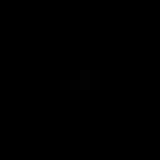

In [10]:
# Generate samples
NG_jet.reset()
NG_pu.reset()
sampled_images = diffusion.sample(batch_size=1)
show_tensor_images(sampled_images, scale_factor=10)
# next(NG_pu)
# next(NG_jet)
# sampled_images = diffusion.sample(batch_size=1)
# show_tensor_images(sampled_images, scale_factor=10)


70901


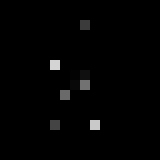

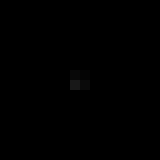

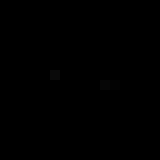

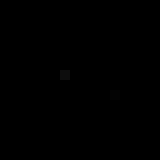

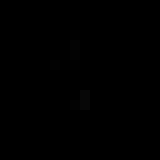

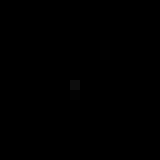

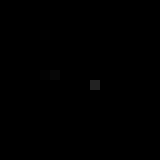

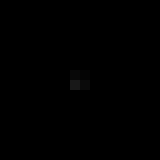

In [11]:
print(len(ng_for_dataloader))
pats = [ng_for_dataloader[0],ng_for_dataloader[1],ng_for_dataloader[2],ng_for_dataloader[3],ng_for_dataloader[4],ng_for_dataloader[5], ng_for_dataloader[-1]]
# print(ng_for_dataloader[0])
ng_for_dataloader_unscaled = ng_for_dataloader[0] * NG_jet.max_energy
show_tensor_images(ng_for_dataloader_unscaled, scale_factor=10)
show_tensor_images(pats, scale_factor=10)

In [12]:
# class PileupDiffusion(GaussianDiffusion):
#     def __init__(
#         self,
#         model,
#         *,
#         image_size,
#         timesteps = 1000,
#         sampling_timesteps = None,
#         objective = 'pred_v',
#         beta_schedule = 'sigmoid',
#         schedule_fn_kwargs = dict(),
#         ddim_sampling_eta = 0.,
#         auto_normalize = True,
#         offset_noise_strength = 0.,  # https://www.crosslabs.org/blog/diffusion-with-offset-noise
#         min_snr_loss_weight = False, # https://arxiv.org/abs/2303.09556
#         min_snr_gamma = 5,
#         immiscible = False
#     ):
#         super().__init__()